In [ ]:
import Revise

In [2]:
import QuantumCollocation as QC
import NamedTrajectories as NT
import TrajectoryIndexingUtils as NTidx
import LinearAlgebra as LA
import SparseArrays as SA
import ForwardDiff as FD
import Plots
import Interpolations as IP
using LaTeXStrings
import JLD2

using FFTW:ifft, fft, fftshift, fftfreq

In [3]:
include("utils.jl")
include("system.jl")
include("constraints.jl")
include("objectives.jl")

QuadraticObjective (generic function with 3 methods)

In [ ]:
V = 10.
trunc = 13
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=3*trunc)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

In [ ]:
system.params[:bloch_energies]

In [ ]:
system.H_drives_real[1]

df = DF.DataFrame(CSV.File("./paper_data/split_fig6_coarse.csv"; header=0))

times = df[:,1] * E_R
dts = times[2:end] - times[1:end-1]
#push!(dts, dts[end])
#push!(dts, 0.)
phi = df[1:end-1,2]
#push!(phi, 0.)

duration = sum(dts) # in 1/E_R

T = length(dts)
dt_avg = duration / (T-1)
#dts = zeros(T) .+ dt
dt_bound = (minimum(dts), maximum(dts))
times = cumsum(dts) - dts

a_bound = fill(1., 2)
dda_bound = fill(50., 2)

a = vcat(cos.(phi)', sin.(phi)')

da = NT.derivative(a, dts)
dda = NT.derivative(da, dts)

In [ ]:
duration = 2pi * 0.8 # in units of 1/E_R

T = 801
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts
duration

In [ ]:
a_bound = fill(1.0, 2)
phi_bound = [1.0 * pi]
#dphi_bound = [100.]
#ddphi_bound = [3000.]

#phi = collect(sin.(11.5 *times)')
phi = rand(1, T)
a = vcat(cos.(phi), sin.(phi))

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

In [ ]:
Z = NT.load_traj("./interferometer/split_bloch78_time_study/0.6wr.jld2")

NT.plot(Z, (:a, :phi), transformations=Dict(:psi_iso => x -> abs2.(QC.iso_to_ket(x))))

In [ ]:
a, phi, dts = Z.a, Z.phi, vec(Z.dts)
# dts_new = fill(0.3*2pi/300, 301)
# a = interpolate_controls(a, dts, dts_new)
# dts = dts_new

# phi = collect(atan.(a[2,:], a[1,:])')
# phi_mod_clean!(phi)

slice = 1:length(dts)
a = a[:,slice]
dts = dts[slice]
phi = phi[:,slice]

times = cumsum(dts) - dts
T = length(times)

In [ ]:
duration = times[end]
T = length(times)
dt = duration/(T-1)
dt_bound = (0.9*dt, dt)
T

In [ ]:
a_bound = fill(1.0, 2)
phi_bound = [1.0*pi]
ddphi_bound = [1000.]

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

In [ ]:
duration/2pi

In [ ]:
times

In [ ]:
Plots.plot(times, a')

In [ ]:
Plots.plot(times, phi')

In [ ]:
Plots.plot(times, dphi')

In [ ]:
Plots.plot(times, ddphi')

psi0 = zeros(system.params[:dim])
psi0[mid] = 0.
psi0[mid-1] = sqrt(0.5)
psi0[mid+1] = sqrt(0.5)
normalize!(psi0)

In [ ]:
#psi0 = get_bloch_state(system; lvl=0)
psi0 = QC.cavity_state(0, dim)

In [ ]:
#Plots.bar(-p_max:p_max, abs2.(psi0))
Plots.bar(0:dim-1, abs2.(psi0))

In [ ]:
psi0_iso = QC.ket_to_iso(psi0)

In [ ]:
psi_iso = QC.rollout(psi0_iso, a, dts, system; integrator=exp)

In [ ]:
psi_iso += rand(size(psi_iso)...)

In [ ]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
pops = abs2.(psi)

In [ ]:
#Plots.plot(times, pops[:,:]', labels=(-p_max:1:p_max)', legend=:outertopright)#, xlim=(0.0, 2.0))
Plots.plot(times, pops[:,:]', labels=(0:dim-1)', legend=:outertopright)#, xlim=(0.0, 2.0))

bloch_states = hcat([get_bloch_state(system; lvl=i) for i=0:dim-1]...)

psi

blochs = bloch_states' * psi
bloch_pops = abs2.(blochs)

Plots.plot(times, bloch_pops[:,:]', labels=(0:8)', legend=:outertopright)#, xlim=(0.0, 2.0))

pops[:, end]

In [ ]:
comps = (
    psi_iso = psi_iso,
    a = a,
    phi = phi,
    # dphi = dphi,
    # ddphi = ddphi,
    dts = dts
)
initial = (
    psi_iso = psi0_iso,
    phi = [0.],
    #dphi = [0.]
)
final = (;
    phi = [0.],
    #dphi = [0.]
)
goal = (;)
bounds = (
    phi = phi_bound,
    # ddphi = ddphi_bound,
    dts = dt_bound
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:phi),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

import JLD2

JLD2.save("./interferometer/mirror_victor2.jld2", Z_guess)

Z_guess = NT.copy(Z_save)

NT.update_bounds!(Z_guess, :dda, [-5000. -5000.; 5000. 5000.])

In [ ]:
dim = system.params[:dim]

In [ ]:
R = 1.0 * collect(LA.I(dim))
R[10,10] = R[11,11] = 0.
R = QC.QuantumSystems.iso(R)
# R[8,8] = R[9+dim,9+dim] = 0. # this should get populations right AND fix y-z greatcircle
R

In [ ]:
kernel = sinc_kernel(50., vec(Z_guess.dts))
convolver = LA.I(Z_guess.T) - kernel
convolver = convolver' * convolver

In [ ]:
Z_guess.psi_iso

In [ ]:
state_goal = QC.cavity_state(3, dim)

In [ ]:
#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
# J1 = QC.QuantumObjective(name=:psi_iso, goals=QC.ket_to_iso(state_goal), loss=:InfidelityLoss, Q=100.0)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])

J1 = QuadraticObjective(:psi_iso, Z_guess, R; Q=200.0)
# J2 = NameComponentObjective(:psi_iso, [8, 9], [T], x -> real(x[1]'*x[2])^2, [100.0]; is_iso=true)
# J4 = QC.QuadraticRegularizer(:ddphi, Z_guess, 1e-8/T)
# J5 = QC.QuadraticRegularizer(:dts, Z_guess, 1e1/T)
J5 = NameComponentQuadraticRegularizer(:psi_iso, [13], Z_guess, [1e1/T]; is_iso=true)

# convolution
J4 = QuadraticObjective(:phi, Z_guess, convolver, [1], 1:Z_guess.T; Q=50.0/T)

J = J1 + J4 + J5

In [ ]:
J.L(Z_guess.datavec, Z_guess)

In [ ]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psi_iso,
        :a,
        :dts;
        order=4
    ),
    # QC.DerivativeIntegrator(
    #     :phi,
    #     :dphi,
    #     :dts,
    #     Z_guess
    # ),
    # QC.DerivativeIntegrator(
    #     :dphi,
    #     :ddphi,
    #     :dts,
    #     Z_guess
    # )
]

In [ ]:
constraints = [
    IQPhiConstraint(:a, :phi, Z_guess),
    FinalYZGreatCircleConstraint(:psi_iso, [10, 11], Z_guess)
    #LinearSincConvolutionConstraint(:phi, :dts, Z_guess, 60.)
    #OmegaAbsConstraint(1.0, Z_guess),
    #PhiSincConvolutionConstraint(:a, :dts, Z_guess, 80.),
    #PhiFunctionBoundConstraint(phase_bound, Z_guess),
    #TimeSymmetricControlConstraint(:a, Z_guess)
    #custom_bounds_constraint(:a, Z_guess, Int[], a_bound)
]

In [ ]:
# Ipopt options
options = QC.Options(
    max_iter=200,
)

In [ ]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    integrators;
    constraints=constraints,
    options=options,
)

In [ ]:
QC.solve!(prob)

In [ ]:
Z = nothing
GC.gc()
Z = prob.trajectory

In [ ]:
Z.psi_iso

In [ ]:
psi_iso_rollout = QC.rollout(psi0_iso, Z.a, Z.dts, system; integrator=exp)
psi = hcat([QC.iso_to_ket(psi_iso_rollout[:,t]) for t=1:T]...)
pops = abs2.(psi)

psi = hcat([QC.iso_to_ket(Z.psi_iso[:,t]) for t=1:T]...)
pops = hcat([abs2.(QC.iso_to_ket(Z.psi_iso[:,t])) for t=1:T]...)

In [ ]:
psi[:,end]

In [ ]:
angle(psi[8,end]) - angle(psi[9,end])

In [ ]:
1 - J1.L(Z.datavec, Z)/100

In [ ]:
J4.L(Z.datavec, Z)

x = QC.iso_to_ket(Z.psi_iso[:,end])

x / exp(1im*angle(x[8]))

In [ ]:
pops_goal

In [ ]:
times = cumsum(Z.dts[1,:]) - Z.dts[1,:]

In [ ]:
#p = Plots.plot(times, pops[:,:]', labels=(-p_max:1:p_max)', legend=:outertopright, size=(500, 300))
p = Plots.plot(times, pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, "Splitting shaking sequence")

In [ ]:
Plots.plot(times, pops[end,:])

blochs = bloch_states' * psi
bloch_pops = abs2.(blochs)

p = Plots.plot(times, bloch_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\nu_R]$"
)
Plots.yaxis!(p, 
    ylabel=L"population of Bloch state $|B\rangle$"
)
Plots.title!(p, "Splitting shaking sequence")

In [ ]:
Plots.plot(times, Z.a')

In [ ]:
Plots.plot(times, Z.phi')

In [ ]:
dphi = NT.derivative(Z.phi, dts)
ddphi = NT.derivative(dphi, dts);

In [ ]:
Plots.plot(times, dphi')

In [ ]:
Plots.plot(times, ddphi')

In [ ]:
times_f1 = times[div(2*T,3):end]
sin_f1 = pi/2*sin.(29.6*(times_f1 .- 0.27)) .- pi/2
times_f2 = times[1:div(2*T,3)]
sin_f2 = pi*sin.(11.5*(times_f2));

In [ ]:
p = Plots.plot(times, Z.phi', linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
Plots.plot!(p, times_f1, sin_f1, linecolor=:red, alpha=0.2, label=L"\omega=29.6")
Plots.plot!(p, times_f2, sin_f2, linecolor=:green, alpha=0.2, label=L"\omega=11.5")
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, "Splitting shaking sequence")

In [ ]:
Z_guess = Z
Z_save = NT.copy(Z)

In [ ]:
import JLD2

In [ ]:
duration_wr = round(duration/2pi; digits=2)

In [ ]:
duration = sum(Z.dts) - Z.dts[end]
duration_wr = round(duration/2pi; digits=2)
s = """
Final infidelity (Bloch 3) in %:
$(J1.L(Z.datavec, Z))
"""
write("$(duration_wr)wr.txt", s)

In [ ]:
JLD2.save("interferometer/split_bloch910_time_study/$(duration_wr)wr.jld2", Z)

In [ ]:
function fourier_time_freq(data_time, times, freqs)
    dts = times[2:end] - times[1:end-1]
    push!(dts, dts[end])
    ft_mat = exp.(2im*pi*freqs*times')
    data_freq = (dts' .* ft_mat) * data_time / sqrt.(2pi)
    return data_freq
end

In [ ]:
slice = 1:T #div(2*T,3):T

In [ ]:
freqs = collect(0:0.1:80)
phi_ft = fourier_time_freq(Z.phi[1,slice], times[slice], freqs/2pi);

In [ ]:
p = Plots.plot(freqs, abs2.(phi_ft), size=(500, 300), label=nothing)
Plots.xaxis!(p, 
    xlabel=L"$\omega$ $[\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Fourier amplitude"
)
Plots.title!(p, "Shaking protocol spectrum")

In [ ]:
dphi = NT.derivative(Z.phi, dts)

In [ ]:
Plots.plot(times, dphi')

In [ ]:
ddphi = NT.derivative(dphi, dts)

In [ ]:
Plots.plot(times, ddphi')

# mirror (free rel phase)

In [ ]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=2*trunc)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

In [ ]:
duration = 2pi * 1.0 # in units of 1/E_R

T = 1001
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts
duration

In [ ]:
a_bound = fill(1.0, 2)
phi_bound = [1.0 * pi]
#dphi_bound = [100.]
#ddphi_bound = [3000.]

phi = collect((sin.(11.5 *times) + sin.(20.0 * times) + sin.(27.0 * times))')
#phi = rand(1, T)
a = vcat(cos.(phi), sin.(phi))

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

In [ ]:
Z1 = NT.load_traj("./interferometer/bloch_7_to_3.jld2")
Z2 = NT.load_traj("./interferometer/mirror_victor2.jld2")

In [ ]:
Z1.dts, Z2.dts

In [ ]:
a, dts = get_interferometer(Z1, Z2, [])
times = cumsum(dts) - dts
T = length(times)

In [ ]:
Z = NT.load_traj("./interferometer/mirror_bloch7_bitshorter.jld2")

In [ ]:
a, dts = Z.a, vec(Z.dts)
phi = collect(atan.(a[2,:], a[1,:])')

slice = 1:length(dts)
a = a[:,slice]
dts = dts[slice]
phi = phi[:,slice]

times = cumsum(dts) - dts
duration = times[end]
T = length(times)

T_new = 600
dt_new = duration[end]/(T_new-1)
dts_new = fill(dt_new, T_new);

a = interpolate_controls(a, dts, dts_new)
times = cumsum(dts_new) - dts_new;

In [ ]:
duration = times[end]
T = length(times)
dt = duration/(T-1)
dt_bound = (dt, dt)
T

In [ ]:
a_bound = fill(1.0, 2)
phi_bound = [1*pi]
ddphi_bound = [1000.]

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

In [ ]:
Plots.plot(times, a')

In [ ]:
Plots.plot(times, phi')

In [ ]:
Plots.plot(times, dphi')

In [ ]:
Plots.plot(times, ddphi')

In [ ]:
p = Plots.plot(times, phi', linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$ (guess)")

psi0 = zeros(system.params[:dim])
psi0[mid] = 0.
psi0[mid-1] = sqrt(0.5)
psi0[mid+1] = sqrt(0.5)
normalize!(psi0)

#####Victor solution
function get_pw_sin(sin_amps, sin_dts)
    N = length(sin_amps)
    sin_T = length(sin_dts)
    T = N*sin_T + 1
    sin_times = cumsum(sin_dts) - sin_dts
    sin_time = sin_times[end]
    dts = repeat(sin_dts, N)
    push!(dts, 0.)
    phi = zeros(T)
    for i=1:N
        phi[(i-1)*sin_T+1:i*sin_T] = (-1)^(i-1) * sin_amps[i] * sin.(pi*sin_times/sin_time)
    end
    a = zeros(2, T)
    a[1,:] = cos.(phi)
    a[2,:] = sin.(phi)
    return a, dts, cumsum(dts) - dts
end

sin_amps = [0.3926, 0.6872, 0.6872, 0.4908, 0.4908, 0.7853, 0.7853]
append!(sin_amps, sin_amps[end:-1:1]) 

freq = 11.5
sin_time = 2pi * 1/freq / 2
sin_T = 20
sin_dts = fill(sin_time / sin_T, sin_T)
a, dts, times = get_pw_sin(sin_amps, sin_dts)
T = length(times)

a_bound = fill(1., 2)
dda_bound = fill(10000., 2)
dt_bound = (dts[1], dts[1])

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

In [ ]:
#psi0 = get_bloch_state(system; lvl=3)
bloch_subspace = [7, 8]
psip0 = QC.cavity_state(bloch_subspace[1], dim) + QC.cavity_state(bloch_subspace[2], dim)
normalize!(psip0) 
psim0 = QC.cavity_state(bloch_subspace[1], dim) - QC.cavity_state(bloch_subspace[2], dim)
normalize!(psim0)

In [ ]:
system.params[:bloch_energies]

In [ ]:
psip0_iso = QC.ket_to_iso(psip0)
psim0_iso = QC.ket_to_iso(psim0)

In [ ]:
psip_iso = QC.rollout(psip0_iso, a, dts, system; integrator=exp)
psim_iso = QC.rollout(psim0_iso, a, dts, system; integrator=exp)

In [ ]:
psip = hcat([QC.iso_to_ket(psip_iso[:,t]) for t=1:T]...)
psip_pops = abs2.(psip)
psim = hcat([QC.iso_to_ket(psim_iso[:,t]) for t=1:T]...)
psim_pops = abs2.(psim)

In [ ]:
x = 3

In [ ]:
p = Plots.plot(times, psip_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle$ (guess)")

In [ ]:
p = Plots.plot(times, psim_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle$ (guess)")

In [ ]:
comps = (
    psip_iso = psip_iso,
    psim_iso = psim_iso,
    a = a,
    phi = phi,
    dts = dts
)
initial = (
    psip_iso = psip0_iso,
    psim_iso = psim0_iso,
    phi = [0.]
)
final = (;
    phi = [0.]
)
goal = (;)
bounds = (
    phi = phi_bound,
    dts = dt_bound
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:phi),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

In [ ]:
kernel = sinc_kernel(40., vec(Z_guess.dts))
convolver = LA.I(Z_guess.T) - kernel
convolver = convolver' * convolver

In [ ]:
dim = system.params[:dim]

#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
J1 = QC.QuantumObjective(name=:psip_iso, goals=psim0_iso, loss=:InfidelityLoss, Q=100.0)
J1 += QC.QuantumObjective(name=:psim_iso, goals=psip0_iso, loss=:InfidelityLoss, Q=100.0)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])
#J += QC.QuadraticRegularizer(:ddphi, Z_guess, 1e-8/T)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])

# J1 = QuadraticObjective(:psi_iso, Z_guess, R; Q=200.0)
# J2 = NameComponentObjective(:psi_iso, [8, 9], [T], x -> real(x[1]'*x[2])^2, [100.0]; is_iso=true)
# J3 = QC.QuadraticRegularizer(:ddphi, Z_guess, 1e-5/T)

# convolution
J4 = QuadraticObjective(:phi, Z_guess, convolver, [1], 1:Z_guess.T; Q=50.0/T)

J = J1 + J4

In [ ]:
J.L(Z_guess.datavec, Z_guess)

In [ ]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psip_iso,
        :a,
        :dts;
        order=4
    ),
    QC.QuantumStatePadeIntegrator(
        system,
        :psim_iso,
        :a,
        :dts;
        order=4
    ),
]

In [ ]:
constraints = [
    IQPhiConstraint(:a, :phi, Z_guess),
    #LinearSincConvolutionConstraint(:phi, :dts, Z_guess, 60.)
    #OmegaAbsConstraint(1.0, Z_guess),
    #PhiSincConvolutionConstraint(:a, :dts, Z_guess, 80.),
    #PhiFunctionBoundConstraint(phase_bound, Z_guess),
    #TimeSymmetricControlConstraint(:a, Z_guess)
    #custom_bounds_constraint(:a, Z_guess, Int[], a_bound)
]

In [ ]:
# Ipopt options
options = QC.Options(
    max_iter=200,
)

In [ ]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    integrators;
    constraints=constraints,
    options=options,
)

In [ ]:
QC.solve!(prob)

In [ ]:
Z = nothing
GC.gc()
Z = prob.trajectory

In [ ]:
Z = NT.load_traj("interferometer/mirror_bloch78_freerelphase.jld2")

In [ ]:
psip_iso_rollout = QC.rollout(psip0_iso, Z.a, Z.dts, system; integrator=exp)
psip = hcat([QC.iso_to_ket(psip_iso_rollout[:,t]) for t=1:Z.T]...)
popsp = abs2.(psip)

psim_iso_rollout = QC.rollout(psim0_iso, Z.a, Z.dts, system; integrator=exp)
psim = hcat([QC.iso_to_ket(psim_iso_rollout[:,t]) for t=1:Z.T]...)
popsm = abs2.(psim)

psi = hcat([QC.iso_to_ket(Z.psi_iso[:,t]) for t=1:T]...)
pops = hcat([abs2.(QC.iso_to_ket(Z.psi_iso[:,t])) for t=1:T]...)

In [ ]:
abs2.(psip[:,end]' * psim0)

In [ ]:
abs2.(psim[:,end]' * psip0)

In [ ]:
times = cumsum(Z.dts[1,:]) - Z.dts[1,:]

In [ ]:
p = Plots.plot(times, popsp[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle$")

In [ ]:
p = Plots.plot(times, popsm[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle$")

In [ ]:
Plots.plot(times, Z.a')

In [ ]:
Plots.plot(times, Z.phi')

In [ ]:
Plots.plot(times, Z.dphi')

In [ ]:
Plots.plot(times, Z.ddphi')

In [ ]:
p = Plots.plot(times, Z.phi', linecolor=:blue, label=L"\varphi(t)", size=(700, 300))
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$")

In [ ]:
pops[:,end]

In [ ]:
Plots.plot(times, acos.(Z.a[1,:]))

In [ ]:
Z_guess = Z
Z_save = deepcopy(Z)

In [ ]:
Z_guess = trajectory_shrink_extend(Z, 1001)

In [ ]:
import JLD2

In [ ]:
JLD2.save("interferometer/mirror_bloch78_freerelphase.jld2", Z)

In [ ]:
function fourier_time_freq(data_time, times, freqs)
    dts = times[2:end] - times[1:end-1]
    push!(dts, dts[end])
    ft_mat = exp.(2im*pi*freqs*times')
    data_freq = (dts' .* ft_mat) * data_time / sqrt.(2pi)
    return data_freq
end

In [ ]:
freqs = collect(0:0.1:60)
phi_ft = fourier_time_freq(Z.a[2,:], times, freqs/(2pi));
#phi_ft = fourier_time_freq(phi, times, freqs/(2pi));

In [ ]:
Plots.plot(freqs, abs2.(phi_ft))#, ylims=(0.0, 0.01))

# mirror (Z gate)

In [ ]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=2*trunc, odd_even_fix_above_degeneracy_diff=1e-20)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

In [ ]:
duration = 2pi * 1.0 # in units of 1/E_R

T = 1001
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts
duration

In [ ]:
a_bound = fill(1.0, 2)
phi_bound = [1.0 * pi]
#dphi_bound = [100.]
#ddphi_bound = [3000.]

#phi = collect((sin.(11.5 *times) + sin.(20.0 * times) + sin.(27.0 * times))')
phi = rand(1, T)
phi = zeros(1, T)
a = vcat(cos.(phi), sin.(phi))

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

In [ ]:
Plots.plot(times, a')

In [ ]:
Plots.plot(times, phi')

In [ ]:
Plots.plot(times, dphi')

In [ ]:
Plots.plot(times, ddphi')

In [ ]:
p = Plots.plot(times, phi', linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$ (guess)")

psi0 = zeros(system.params[:dim])
psi0[mid] = 0.
psi0[mid-1] = sqrt(0.5)
psi0[mid+1] = sqrt(0.5)
normalize!(psi0)

#####Victor solution
function get_pw_sin(sin_amps, sin_dts)
    N = length(sin_amps)
    sin_T = length(sin_dts)
    T = N*sin_T + 1
    sin_times = cumsum(sin_dts) - sin_dts
    sin_time = sin_times[end]
    dts = repeat(sin_dts, N)
    push!(dts, 0.)
    phi = zeros(T)
    for i=1:N
        phi[(i-1)*sin_T+1:i*sin_T] = (-1)^(i-1) * sin_amps[i] * sin.(pi*sin_times/sin_time)
    end
    a = zeros(2, T)
    a[1,:] = cos.(phi)
    a[2,:] = sin.(phi)
    return a, dts, cumsum(dts) - dts
end

sin_amps = [0.3926, 0.6872, 0.6872, 0.4908, 0.4908, 0.7853, 0.7853]
append!(sin_amps, sin_amps[end:-1:1]) 

freq = 11.5
sin_time = 2pi * 1/freq / 2
sin_T = 20
sin_dts = fill(sin_time / sin_T, sin_T)
a, dts, times = get_pw_sin(sin_amps, sin_dts)
T = length(times)

a_bound = fill(1., 2)
dda_bound = fill(10000., 2)
dt_bound = (dts[1], dts[1])

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

In [ ]:
#psi0 = get_bloch_state(system; lvl=3)
bloch_subspace = [7, 8]
psi0 = QC.cavity_state(bloch_subspace[1], dim)
psip0 = QC.cavity_state(bloch_subspace[1], dim) + QC.cavity_state(bloch_subspace[2], dim)
normalize!(psip0) 
psim0 = QC.cavity_state(bloch_subspace[1], dim) - QC.cavity_state(bloch_subspace[2], dim)
normalize!(psim0)

In [ ]:
system.params[:bloch_energies]

In [ ]:
psi0_iso = QC.ket_to_iso(psi0)
psip0_iso = QC.ket_to_iso(psip0)

In [ ]:
psi_iso = QC.rollout(psi0_iso, a, dts, system; integrator=exp)
psip_iso = QC.rollout(psip0_iso, a, dts, system; integrator=exp)

In [ ]:
psi_iso += rand(size(psi_iso)...)
psip_iso += rand(size(psip_iso)...)

In [ ]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
psi_pops = abs2.(psi)
psip = hcat([QC.iso_to_ket(psip_iso[:,t]) for t=1:T]...)
psip_pops = abs2.(psip)

In [ ]:
p = Plots.plot(times, psi_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle \rightarrow |%$(bloch_subspace[1])\rangle$ (guess)")

In [ ]:
p = Plots.plot(times, psip_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle$ (guess)")

In [ ]:
comps = (
    psi_iso = psi_iso,
    psip_iso = psip_iso,
    a = a,
    phi = phi,
    dts = dts
)
initial = (
    psi_iso = psi0_iso,
    psip_iso = psip0_iso,
    phi = [0.]
)
final = (;
    phi = [0.]
)
goal = (;)
bounds = (
    phi = phi_bound,
    dts = dt_bound
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:phi),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

In [ ]:
kernel = sinc_kernel(40., vec(Z_guess.dts))
convolver = LA.I(Z_guess.T) - kernel
convolver = convolver' * convolver

In [ ]:
dim = system.params[:dim]

#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
J1 = QC.QuantumObjective(name=:psip_iso, goals=QC.ket_to_iso(psim0), loss=:InfidelityLoss, Q=100.0)
J1 += QC.QuantumObjective(name=:psi_iso, goals=psi0_iso, loss=:InfidelityLoss, Q=100.0)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])
#J += QC.QuadraticRegularizer(:ddphi, Z_guess, 1e-8/T)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])

# J1 = QuadraticObjective(:psi_iso, Z_guess, R; Q=200.0)
# J2 = NameComponentObjective(:psi_iso, [8, 9], [T], x -> real(x[1]'*x[2])^2, [100.0]; is_iso=true)
# J3 = QC.QuadraticRegularizer(:ddphi, Z_guess, 1e-5/T)

# convolution
J4 = QuadraticObjective(:phi, Z_guess, convolver, [1], 1:Z_guess.T; Q=50.0/T)

J = J1 + J4

In [ ]:
J.L(Z_guess.datavec, Z_guess)

In [ ]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psi_iso,
        :a,
        :dts;
        order=4
    ),
    QC.QuantumStatePadeIntegrator(
        system,
        :psip_iso,
        :a,
        :dts;
        order=4
    ),
]

In [ ]:
constraints = [
    IQPhiConstraint(:a, :phi, Z_guess),
    QC.ComplexModulusContraint(
        R=sqrt(0.1),
        comps=Z_guess.components[:psi_iso][[3, 3+dim]],
        times=[div(Z_guess.T, 2)],
        zdim=Z_guess.dim,
        T=Z_guess.T,
        negated=true
    )
    #LinearSincConvolutionConstraint(:phi, :dts, Z_guess, 60.)
    #OmegaAbsConstraint(1.0, Z_guess),
    #PhiSincConvolutionConstraint(:a, :dts, Z_guess, 80.),
    #PhiFunctionBoundConstraint(phase_bound, Z_guess),
    #TimeSymmetricControlConstraint(:a, Z_guess)
    #custom_bounds_constraint(:a, Z_guess, Int[], a_bound)
]

In [ ]:
# Ipopt options
options = QC.Options(
    max_iter=200,
)

In [ ]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    integrators;
    constraints=constraints,
    options=options,
)

In [ ]:
QC.solve!(prob)

In [ ]:
Z = nothing
GC.gc()
Z = prob.trajectory

In [ ]:
psi_iso_rollout = QC.rollout(psi0_iso, Z.a, Z.dts, system; integrator=exp)
psi = hcat([QC.iso_to_ket(psi_iso_rollout[:,t]) for t=1:Z.T]...)
pops = abs2.(psi)

psip_iso_rollout = QC.rollout(psip0_iso, Z.a, Z.dts, system; integrator=exp)
psip = hcat([QC.iso_to_ket(psip_iso_rollout[:,t]) for t=1:Z.T]...)
popsp = abs2.(psip)

psi = hcat([QC.iso_to_ket(Z.psi_iso[:,t]) for t=1:T]...)
pops = hcat([abs2.(QC.iso_to_ket(Z.psi_iso[:,t])) for t=1:T]...)

In [ ]:
abs2.(psi[:,end]' * psi0)

In [ ]:
abs2.(psip[:,end]' * psim0)

In [ ]:
times = cumsum(Z.dts[1,:]) - Z.dts[1,:]

In [ ]:
p = Plots.plot(times, pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle \rightarrow |%$(bloch_subspace[1])\rangle$")

In [ ]:
p = Plots.plot(times, popsp[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle$")

In [ ]:
Plots.plot(times, Z.a')

In [ ]:
Plots.plot(times, Z.phi')

In [ ]:
Plots.plot(times, Z.dphi')

In [ ]:
Plots.plot(times, Z.ddphi')

In [ ]:
p = Plots.plot(times, Z.phi', linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$")

In [ ]:
pops[:,end]

In [ ]:
Plots.plot(times, acos.(Z.a[1,:]))

In [ ]:
Z_guess = Z
Z_save = deepcopy(Z)

In [ ]:
Z_guess = trajectory_shrink_extend(Z, 1001)

In [ ]:
import JLD2

In [ ]:
JLD2.save("interferometer/mirror_bloch78_Z.jld2", Z)

In [ ]:
function fourier_time_freq(data_time, times, freqs)
    dts = times[2:end] - times[1:end-1]
    push!(dts, dts[end])
    ft_mat = exp.(2im*pi*freqs*times')
    data_freq = (dts' .* ft_mat) * data_time / sqrt.(2pi)
    return data_freq
end

In [ ]:
freqs = collect(0:0.1:60)
phi_ft = fourier_time_freq(Z.a[2,:], times, freqs/(2pi));
#phi_ft = fourier_time_freq(phi, times, freqs/(2pi));

In [ ]:
Plots.plot(freqs, abs2.(phi_ft))#, ylims=(0.0, 0.01))

## convergence plot

In [163]:
L = zeros(201)
grad = zeros(201)
open("convergence2.txt") do f
    global L, grad
    while !eof(f)
        s = strip(readline(f))
        pcs = split(s, " ")
        pcs = filter(x -> x != "", pcs)
        try
            i = parse(Int, pcs[1])
        catch
            println("catch")
            continue
        end
        L[i+1] = parse(Float64, pcs[2])
        grad[i+1] = parse(Float64, pcs[6])
        i += 1
    end
end

catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch


In [164]:
L = hcat(L, zeros(201))
grad = hcat(grad, zeros(201))
open("convergence1.txt") do f
    global L, grad
    while !eof(f)
        s = strip(readline(f))
        pcs = split(s, " ")
        pcs = filter(x -> x != "", pcs)
        try
            i = parse(Int, pcs[1])
        catch
            println("catch")
            continue
        end
        L[i+1,2] = parse(Float64, pcs[2])
        grad[i+1,2] = parse(Float64, pcs[6])
        i += 1
    end
end

catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch


In [165]:
L

201×2 Matrix{Float64}:
 126.28       126.28
 109.415      116.074
 108.783      101.327
 122.668      100.826
 122.594      100.525
 120.363      100.635
 119.947      100.51
 122.265      100.42
 123.537      100.334
 122.958      100.258
   ⋮          
   0.101583   100.0
   0.101547   100.0
   0.094748   100.0
   0.0906403  100.0
   0.11058    100.0
   0.0931546  100.0
   0.0922879  100.0
   0.103963   100.0
   0.101276   100.0

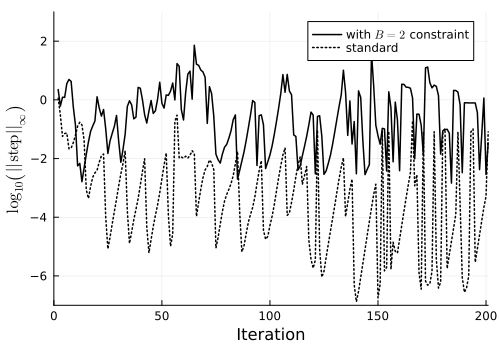

In [173]:
p = Plots.plot(
    log10.(grad),
    size=(500,350),
    label=[L"with $B=2$ constraint" "standard"], 
    legend=:topright,
    xlabel="Iteration",
    ylabel=L"\log_{10}\left(||\!\mathrm{step}\,|\!|_\infty\right)",
    ylim=(-7, 3),
    xlim=(0, 201),
    c=:black,
    linestyle=[:solid :dot],
    linewidth=1.5
    )

In [174]:
Plots.savefig(p, "patent_figs/step_size.pdf")

"/local/lmseifert/Infleqtion/research-superstaq/research_superstaq/theory/shaken_lattice/Max_QC/patent_figs/step_size.pdf"

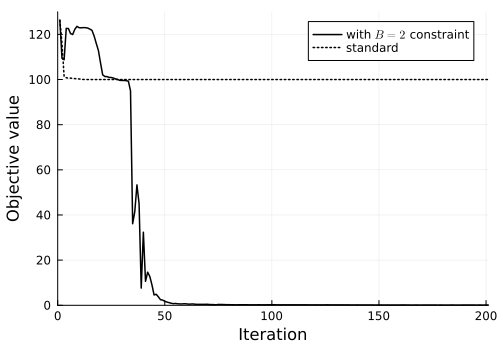

In [175]:
p = Plots.plot(
    L, 
    size=(500,350),
    label=[L"with $B=2$ constraint" "standard" ], 
    legend=:topright,
    xlabel="Iteration",
    ylabel="Objective value",
    xlim=(0, 201),
    ylim=(0., 130.),
    c=:black,
    linestyle=[:solid :dot],
    linewidth=1.5
    )

In [176]:
Plots.savefig(p, "patent_figs/convergence.pdf")

"/local/lmseifert/Infleqtion/research-superstaq/research_superstaq/theory/shaken_lattice/Max_QC/patent_figs/convergence.pdf"